<a href="https://colab.research.google.com/github/FabianDus1002/Data-Mining-Team9/blob/model%2Ffinetuned-BERT/FineTuneSentimentBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import logging

In [2]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none

In [3]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [4]:
# Generate dataset from excel file

drive.mount('/content/drive')

train_data = '/content/drive/MyDrive/Colab Notebooks/FineTuneBERT/data/subset_studium_german.xlsx'

df = pd.read_excel(train_data)

print(df.head())
print(df.shape)

Mounted at /content/drive
   Unnamed: 0                                            Studium  \
0           0  Die Vorlesungszeit war von Anfang September bi...   
1           1  Die Pazmany Universität ist sehr klein im Verg...   
2           2  Mit der Universität selbst hatten wir wenig zu...   
3           3  Da die Vorlesungen wegen der Pandemie online s...   
4           4  Die City University of Hong Kong hat eine groß...   

  Studium_Label                                    Studium_Comment  
0       neutral  pos:\nVielzahl an Kursen, praxisnäher, Sprachn...  
1      positive  pos:\nsehr klein was ich schön und angenehm fa...  
2       neutral  neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...  
3      positive  pos:\nnette Mensa, großes Kursangebot, leichte...  
4      negative  neg: \nhoher Workload, Bewertung intransparent...  
(6119, 4)


In [5]:
df.drop(columns=["Studium_Comment"], inplace=True)

# drop entries where null value -> all unlabeled records
df = df.dropna()

# map sentiment label to numerical value:
# negative -> 0
# neutral -> 1
# positive -> 2

for index, row, in df.iterrows():
  if row["Studium_Label"] == "negative":
    df.at[index,'Studium_Label'] = 0
  elif row["Studium_Label"] == "neutral":
    df.at[index, "Studium_Label"] = 1
  elif row["Studium_Label"] == "positive":
    df.at[index, "Studium_Label"] = 2


# change column names to expected name for transformer lib
df["label"] = df["Studium_Label"]
df["text"] = df["Studium"]
df.drop(columns=["Studium", "Studium_Label"], inplace=True)

print(df.head())

   Unnamed: 0 label                                               text
0           0     1  Die Vorlesungszeit war von Anfang September bi...
1           1     2  Die Pazmany Universität ist sehr klein im Verg...
2           2     1  Mit der Universität selbst hatten wir wenig zu...
3           3     2  Da die Vorlesungen wegen der Pandemie online s...
4           4     0  Die City University of Hong Kong hat eine groß...


<ipython-input-5-4cb458c555c7>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["Studium_Label"]
<ipython-input-5-4cb458c555c7>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["Studium"]
<ipython-input-5-4cb458c555c7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Stu

In [6]:
datasets = Dataset.from_pandas(df).train_test_split(test_size=0.25, seed=42)

In [7]:
# Export files for evaluating with other models
datasets["test"].to_csv("test_dataset.csv")
datasets["train"].to_csv("train_dataset.csv")

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1414120

## Baseline Model

Fine-tune BERT with a simple hold-out method

In [61]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
def tokenize_function(data):
  return tokenizer(data["text"], padding="max_length", truncation=True)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/768 [00:00<?, ? examples/s]

Map:   0%|          | 0/257 [00:00<?, ? examples/s]

In [62]:
model = AutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-german-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="micro")

In [64]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    num_train_epochs=3)

In [65]:
baseline_trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=tokenized_datasets["train"],

    eval_dataset=tokenized_datasets["test"],

    compute_metrics=compute_metrics,
)

In [66]:
baseline_training = baseline_trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.001407,0.455253
2,No log,1.024316,0.482490
3,No log,0.965148,0.517510


## Build a (more) balanced training data set for improve performance of BERT

The dataset is strongly imbalanced because the majority of responses are either neutral or positive. Only a small subset contains negative results. To have a well generalizing model, we need to ensure a balanced training data set. Therefore we use the approach of semi-supervised learning:

https://www.ibm.com/topics/semi-supervised-learning

With the approach of semi-supervised learning we were able to find a handful of other examples in the around 6000 records that we can additionally label as negative sentiment and use for our training purpose.

However, this process also needs a lot of manual effort because the sentiment assigned by BERT is in most cases not according to our understanding of a negative sentiment and hence need manual evaluation.

All training records that we have labeled as negative with this approach have the comment "semi-supervised" in the comment section.


In [ ]:
train_data = '/content/drive/MyDrive/Colab Notebooks/FineTuneBERT/data/subset_studium_german.xlsx'

df = pd.read_excel(train_data)

# drop entries that are already labeled
df = df[df["Studium_Label"].isna()]

# drop entries where text value is null
df = df.dropna(subset=["Studium"])

# set column of label in first position
df = df.reindex(columns=["Studium_Label", "Studium", "Unnamed: 0"])

# change column names
df["label"] = df["Studium_Label"]
df["text"] = df["Studium"]
df.drop(columns=["Studium", "Studium_Label"], inplace=True)

print(df.info())

unlabeled_dataset = Dataset.from_pandas(df)

tokenized_unlabeled_dataset = unlabeled_dataset.map(tokenize_function, batched=True)

print(tokenized_unlabeled_dataset)

<class 'pandas.core.frame.DataFrame'>
Index: 5093 entries, 9 to 6117
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5093 non-null   int64 
 1   label       0 non-null      object
 2   text        5093 non-null   object
dtypes: int64(1), object(2)
memory usage: 159.2+ KB
None


Map:   0%|          | 0/5093 [00:00<?, ? examples/s]

Dataset({
    features: ['Unnamed: 0', 'label', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5093
})


In [ ]:
predictions = trainer.predict(test_dataset=tokenized_unlabeled_dataset)

KeyboardInterrupt: 

In [ ]:
index = 0
threshold = 0.75
for pred in predictions.predictions:
  if pred[0] > pred[1] and pred[0] > pred[2] and pred[0] > threshold:
    print (str(index) + ": negative, " + str(pred[0]))
    print("Dataframe Index in subset: " + str(tokenized_unlabeled_dataset[index]["Unnamed: 0"]))
    print(tokenized_unlabeled_dataset[index]["text"] + "\n")
  elif pred[1] > pred[0] and pred[1] > pred[2]:
    pass
    # print (str(index) + ": neutral, " + str(pred[0]))
  elif pred[2] > pred[0] and pred[2] > pred[1]:
     pass
     # print (str(index) + ": positive, " + str(pred[0]))
     # (tokenized_unlabeled_dataset[index]["text"] + "\n")

  index += 1

## Hyperparameter Optimization
Varying with the most common hyperparameter. Hyperparameter optimization with lage models like BERT is cost and time intensive and is therefore limited to the scope presented below:

Finding the best set of hp in the following parameter space:

- Epoch: 3 (standard),4,5
- Learning Rate: 5e-05 (standard), 3e-05, 2e-05
- weight_decay
- batch size

In [32]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-german-cased", num_labels=3)

In [27]:
logging.basicConfig(filename='/content/drive/MyDrive/Colab Notebooks/hyperparameter_training.log',
                    level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filemode="a",
                    force=True, # Resets any previous configuration
                    )

In [29]:
datasets_hyperparameter = datasets["train"].train_test_split(test_size=0.11, seed=42)
tokenized_datasets_hyperparameter = datasets_hyperparameter.map(tokenize_function, batched=True)
print(tokenized_datasets_hyperparameter)

Map:   0%|          | 0/683 [00:00<?, ? examples/s]

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'label', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 683
    })
    test: Dataset({
        features: ['Unnamed: 0', 'label', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 85
    })
})


In [31]:
epochs = [3, 4, 5]
lrs = [5e-05, 3e-05, 2e-05]
batch_sizes = [16, 8]
weight_decays = [0.0, 0.15, 0.3]

for epoch in epochs:
  for lr in lrs:
    for batch_size in batch_sizes:
      for weight_decay in weight_decays:
        training_args = TrainingArguments(
            output_dir="test_trainer",
            evaluation_strategy="epoch",
            num_train_epochs=epoch,
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            weight_decay=weight_decay)

        trainer = Trainer(
            model_init=model_init,
            args=training_args,
            train_dataset=tokenized_datasets_hyperparameter["train"],
            eval_dataset=tokenized_datasets_hyperparameter["test"],
            compute_metrics=compute_metrics)

        trainer.train()

        eval_f1 = trainer.evaluate()["eval_f1"]

        print("Epoch: " + str(epoch) + ", Learning rate: " + str(lr) + ", Batch size: " + str(batch_size) + ", Weight_decay: " + str(weight_decay) + ", F1-Score: " + str(eval_f1))
        logging.info("Epoch: " + str(epoch) + ", Learning rate: " + str(lr) + ", Batch size: " + str(batch_size) + ", Weight_decay: " + str(weight_decay) + ", F1-Score: " + str(eval_f1))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

## Model Selection

Find the best model based on the hyperparameter evaluation from previous section

In [24]:
df_hp = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/FineTuneBERT/hyperparameter search.csv", sep=";")
print(df_hp.sort_values(by="F1_score", ascending=False)[:3])

    Epoch Learning_rate  Batch_size  Weight_decay  F1_score
45      5      3,00E-05           8          0.00  0.576471
20      4      5,00E-05          16          0.30  0.564706
19      4      5,00E-05          16          0.15  0.552941


In [34]:
# train on full training set with best performing model from hyperparameter search
#     Epoch Learning_rate  Batch_size  Weight_decay  F1_score
#         5      3,00E-05           8          0.00  0.576471

best_training_args = TrainingArguments(
            output_dir="test_trainer",
            evaluation_strategy="epoch",
            num_train_epochs=5,
            learning_rate=3e-05,
            per_device_train_batch_size=8,
            weight_decay=0.0)

best_trainer = Trainer(
            model_init=model_init,
            args=best_training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            compute_metrics=compute_metrics)

best_trainer.train()

evaluation = best_trainer.evaluate()

print(evaluation)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.980896,0.525292
2,No log,0.908338,0.599222
3,No log,1.196811,0.498054
4,No log,1.031089,0.622568
5,No log,1.229127,0.599222


{'eval_loss': 1.2291274070739746, 'eval_f1': 0.5992217898832685, 'eval_runtime': 8.2807, 'eval_samples_per_second': 31.036, 'eval_steps_per_second': 3.985, 'epoch': 5.0}


## Evaluation

Confusion Matrix for best performing model

In [58]:
predictions = best_trainer.predict(tokenized_datasets["test"])
pred = []
for elem in predictions.predictions:
  if elem[0] > elem[1] and elem[0] > elem[2]:
    pred.append(0)
  elif elem[1] > elem[0] and elem[1] > elem[2]:
    pred.append(1)
  elif elem[2] > elem[0] and elem[2] > elem[1]:
    pred.append(2)
  else:
    raise ValueError

[2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 1, 2, 2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 1, 2, 1, 0, 2]


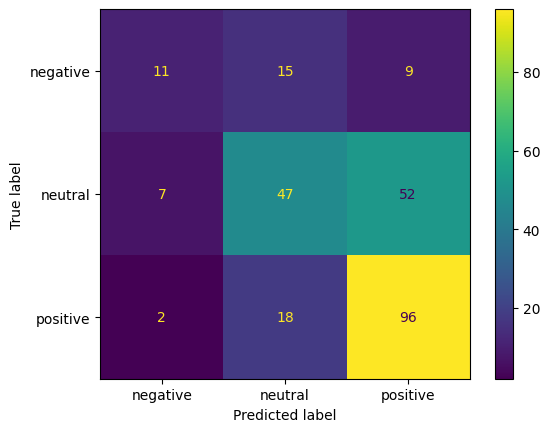

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(tokenized_datasets["test"]["label"], pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["negative", "neutral", "positive"])
disp.plot()
plt.show()

With finetuning we managed to get a better performance measured by a F1-micro-average score than on the german bert baseline model trained in the beginning of this notebook.

F1-score of pretrained-model with finetuning: 0.599

F1-score of pretrained-model: 0.517

Improvement by

$\Delta F1_{incr} = F1_{fine} - F1_{pre} = 0.599 - 0.517 = 0.082$

$\approx 8 \%$ Improvment.